# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.4: Principle Component Analysis (PCA)

# 1.4.1 Principle Component Analysis Introduction

We saw in the last module that multicollinearity is caused when independent variables have a linear relationship. This can cause problems with the OLS estimator, leading to large errors and unreliable coefficients. A few ways to address this was brought up in the last module, such as removing redundant variables.

If there is cause for all variables to be included in a model, another general pattern for solving this type of error is Principle Component Analysis (PCA), which reshapes the data into a new numerical space (vector space). Dimensions in the new space are a linear mapping of dimensions in the old space. For instance, if you have variables $X_1$ and $X_2$, they are the dimensions of your original vector space. After PCA, your first dimension may be $0.5X_1 + 3X_2$ and the data is reshaped according to this variable, rather than the original ones.

The resulting vector-space after running PCA has the following two major properties:

1. The dimensions of the new space are linearly separable, also known as orthogonal to each other. In other words, multicollinearity disappears immediately after running PCA, regardless of the properties of the original dataset.
2. The dimensions are ordered, such that the first dimension accounts for a higher proportion of the variability in the data than the next dimension, and so on.

This second property means that in addition to using PCA to remove multicollinearity, you can also use it to reduce the number of input variables. For instance, if you have 30 input variables, you can use PCA to map them to a new space. In that new space, you may only need 6 variables to account for 95% of the variability in the data, which (very loosely) approximates to a model which can be 95% as effective as the original model, despite having just 20% of the features. Oddly, reducing the number of features this way may actually cause the model to *increase* in predictive accuracy, as the discarded features often map noise rather than signal in your input data (however your results may vary, there are no hard and fast rules here).

An important note to keep in mind is that PCA is an *unsupervised* algorithm. You put your input data variables in, but not your output variable (i.e. the one you are trying to predict). PCA does not care about what you are trying to predict, it will reshape the data in the same way regardless. For this reason, it may, or may not, help with predictive accuracy - the actual PCA results are unrelated to your linear regression model.

<small><i>This notebook/chapter was derived from a notebook put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2015. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>

In [23]:
%run setup.ipy

### PCA basic example

Here is a small example of the PCA algorithm in practice. We start with a dataset with two variables (check `X.shape`), and plot the corresponding data. You can see a strong linear trend to the data between the two variables.

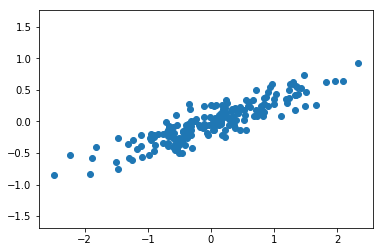

In [24]:
np.random.seed(1)
NDIMS = 2
X = np.dot(np.random.random(size=(NDIMS, NDIMS)), np.random.normal(size=(NDIMS, 200))).T
#X[:,1] = 3 * X[:,1]  # Rescale one dimension
plt.plot(X[:, 0], X[:, 1], 'o')
plt.axis('equal');

In [25]:
X.shape

(200, 2)

After computing PCA, we can instead remap the data onto two dimensions. In this example, this results in the first dimension being the line of best fit, and the second dimension is the (only) dimension orthogonal to it.

We will use the scikit-learn library for doing this analysis. Statsmodels also has a PCA function, which is comparable to this example:

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
pca.explained_variance_ratio_

array([0.97634101, 0.02365899])

In the above data, we can see if we use just one variables though (the original data has 2 variables), we explain 97.6% of the data! Then, we see that if we use all the new features, we explain all the original data (do a cumulative sum) - no information is lost in a PCA transformation, it is just reshaped. Visually this becomes more obvious, especially if we plot the dimensions onto our data.

First, we get the linear combinations that make up the new features:

In [28]:
pca.components_

array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

These two vectors represent the lines of the new, transformed dimensions.
    
You might notice these vectors are orthogonal - this is an expected outcome of the algorithm. We can visualise this result by plotting these lines on top of our graph.

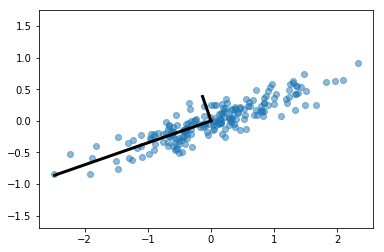

In [29]:
# Plot the original data
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)

# Loop through all the principle components from the model and plot them as a line
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)  # The "3" just scales so the graph looks good
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

In the above graph, we plot the original data, and then the two dimensions found by PCA. The length of the new dimensions are the (relative) weighting.  You can see the first dimension points down and to the left. This is the dimension that explains more than 90% of the data. In other words, if we only knew where a point sits on this line, we have about 94% of the information, compared to if we new its original $X_1$ and $X_2$ values.

For a given data point, we can see where it fits on this line:

In [30]:
pca.components_.shape

(2, 2)

In [31]:
data_index = 36  # Get the data point with this index

point = X[data_index].reshape(-1, 2).T
print(point)

[[-0.51379022]
 [-0.50597409]]


Now that we have a point from our original dataset, we project it onto the first dimension found from PCA. Transforming the original data point, gives the position of the point in the new space.

We set the second projected dimension to zero, so we are just projecting the point onto the first dimension. This reduces the size of the dataset, but as we saw above, it retains more than 97% of the information.

In [32]:
# Invert the transform to project back into the original space
transformed_point = pca.inverse_transform([pca.transform(point.T).T[0], 0])
print(transformed_point)

[-0.61045903 -0.22815074]


To highlight this further, the next segment of code shows the transition from the original data point (in red) to the new data point in yellow in the PCA analysis, which sits on the line found by the PCA model.

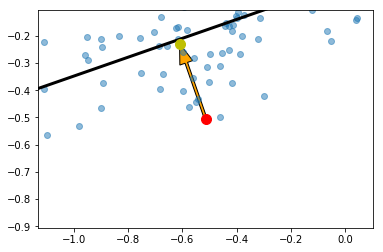

In [33]:
# Start with the same plot as before
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)  # The "3" just scales so the graph looks good
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

# Plot our fixed point in red
plt.plot(point[0], point[1], 'ro', markersize=10)

# Plot the transformed data in orange
plt.plot(transformed_point[0], transformed_point[1], 'yo', markersize=10)


# Zoom into the point to see the transformation more clearly
bbox_size = 0.4
plt.xlim(point[0] - bbox_size, point[0] + bbox_size)
plt.ylim(point[1] - bbox_size, point[1] + bbox_size)

# Draw an arrow from the first point to the second
start_x = point[0, 0]
start_y = point[1, 0]
dx = (transformed_point[0] - point[0])[0]
dy = (transformed_point[1] - point[1])[0]

plt.arrow(start_x, start_y, dx, dy,
              head_width=0.05, length_includes_head=True, width=0.01, facecolor='orange', edgecolor='black',
         alpha=1)

As per the above graph, when we project the red point onto just the first dimension it "moves" the point to the position on that line. Specifically, it moves the point to the line *in the direction orthogonal to the line*. This is opposed to, say, moving vertically until we hit the line (i.e. an arrow pointing straight up), which is a different type of transformation, more akin to what a linear regression would do.

#### Exercise

Use the `statsmodels` library to perform a PCA analysis on the above data, reducing a dataset to fewer features. Extract the transformed data, and the components (lines) themselves. Note that statsmodels refers to these as Eigenvectors, rather than components.

*For solutions, see `solutions/pca_statsmodels.py`*

### PCA on Digits example

To further highlight the power of PCA, we are going to take a dataset of hand-drawn digits with 64 dimensions per digit, run a PCA analysis and plot it onto just two dimensions. This reduces the dataset to approximately 1/32 of the original size. First, let's have a look at what the data looks like:

In [51]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [52]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [53]:
X.shape

(1797, 64)

In [54]:
y[0]

0

A number 0


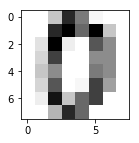

In [55]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(X[0].reshape(8,8), interpolation='nearest', cmap="Greys")
print("A number 0")

In this example, the first data point is a hand drawn zero. All data has 64 dimensions, which are the pixel intensities for an 8 by 8 matrix. Another example:

A number 4


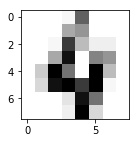

In [56]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(X[4].reshape(8,8), interpolation='nearest', cmap="Greys")
print("A number 4")

In [57]:
X[4,0]

0.0

In the original dimensions, the first variable is simply "how dark is the pixel in this spot?". Higher values are darker for that pixel.

This, by itself, isn't very useful. If I told you "the first pixel is white", you have very little information on what the number is.
In the below visualisation, we can see this in action. If we take the first $n$ dimensions, we get very little information about the number. The figure in "approx" is what we know after taking just the first six features:

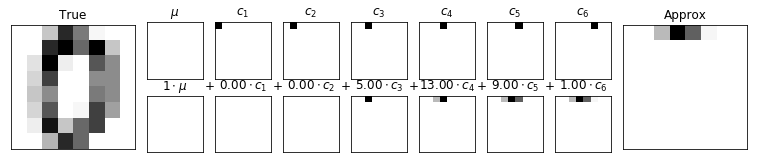

In [58]:
from custom import figures
figures.plot_image_components(X[0])

We start with a base image (all white), add the value for the first pixel (still white), second, third (we see a non-white value). After 6 variables, all we have is the image on the right labelled "Approx". It would be unlikely you would "know" it is a zero after just this amount of data!

Using PCA, we can map these dimensions to more useful set of features:

In [62]:
from sklearn.decomposition import PCA  # Repeated to highlight we are using sklearn's PCA implementation here
digits_pca = PCA()
digits_pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [63]:
X_transformed = digits_pca.transform(X)

In [66]:
from custom import figures
# Move the slider to view a different sample from the database. i is the index of the data point.
figures.plot_pca_interactive(X)

interactive(children=(IntSlider(value=0, description='i', max=1796), Output()), _dom_classes=('widget-interact…

Here, we start with a bias / base image of a weird "S" shape. The PCA analysis has found that this (the mean of the data) is the most useful place to start. The first dimension is visually represented under $c_1$ (the first component). It's weight for this image is -1.26. We multiply the first component by this weight, and add the result to the base image. We still have the S shape for now. Doing the same thing for the second component, suddenly, and with just 2 variables, we get a very clear "zero" in the output in the $c_2$ column at the bottom. After just 6 variables, we have a very clear zero. 

### Visualising all data points

PCA is very useful for visualising data points. Humans can only see in 3 dimensions at maximum, and most communication mediums (reports, journals etc) only allow printing in two dimensions. For this reason, we need to compress our data from its original data point down to two or three dimensions for analysis.

In the next cell, we are going to:
1. Take all digits data (but not the labels of what number they are) as input
2. Perform a PCA with `n_components=2`, meaning just two components are output.
3. Transform the original data onto those two dimensions (similar to what we did earlier)
4. Plot the points:

In [67]:
digits_pca = PCA(n_components=2)
digits_pca.fit(X)
X_transformed = digits_pca.transform(X)
print("Original data shape is", X.shape)
print("Transformed data shape is", X_transformed.shape)

Original data shape is (1797, 64)
Transformed data shape is (1797, 2)


You can see here the reduction in variables from the original 64 variables down to just two.

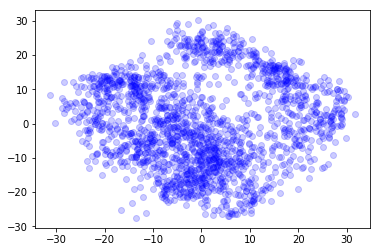

In [68]:
plt.scatter(X_transformed[:,0], X_transformed[:,1], color='blue', alpha=0.2)

This is what the original data looks like in the transformed space. It is a nice visualisation, and we need to do *something*, otherwise we could not visualise all 64 dimensions at the same time. 

Now for the interesting part. For each of the digits, the *general pattern* of the pixel intensities is approximately the same (i.e. all the 8s look approximately the same). It follows that the resulting point in the transformed space would be similar for the same numbers (i.e. the 8s should be in the same spot). If we colour the points according to what the actual number is, we see this in action:

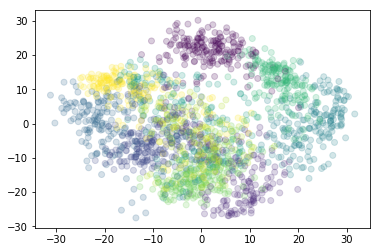

In [69]:
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y, alpha=0.2)

As you can see, similarly labelled data is in a similar space - in *just two dimensions*! This shows that lots of information is contained in those two dimensions. To highlight how amazing this result is, remember that PCA *never knew anything about which samples were which digits*. The separation of digits is based on an analysis of the raw data.


In the next cell, I do the same plot, but split out so the legend can be viewed:

In [70]:
cmap = plt.get_cmap('Set3')

In [74]:
cmap(0)  # A colour map for setting the colour of each different digit.

(0.5529411764705883, 0.8274509803921568, 0.7803921568627451, 1.0)

In [75]:
cmap(2)

(0.7450980392156863, 0.7294117647058823, 0.8549019607843137, 1.0)

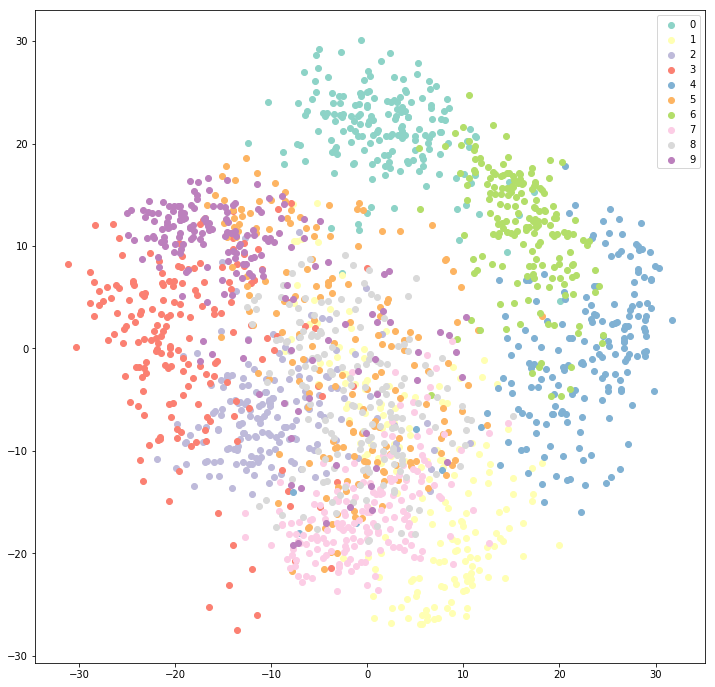

In [76]:
fig, ax = plt.subplots(figsize=(12,12))
for number in np.unique(y):
    ix = np.where(y == number)
    ax.scatter(X_transformed[ix,0], X_transformed[ix,1], c=[cmap(number)], label=number)
ax.legend()


In this plot you can see the individual numbers being separated. Note also the overlaps. For instance, a few numbers are overlapped. This doesn't necessarily mean they are very similar, as we have lost information in performing the PCA.

#### Exercises

1. Plot the relationship between the explained variance score and the number of features. You can get this from a PCA with the number of components equal to the actual number of features, and extract the explained variance ratio as a vector from the trained model. Hint: use NumPy's cumulative sum.
2. Try the same analysis with several other datasets. Compare the graphs to get a general sense of the shape, and the approximate level of variance that it changes. Note the shape is generally the same.

*For solutions, see `solutions/pca_explained_variance.py`*